In [126]:
import anndata as ad
import scanpy as sc
from sklearn.model_selection import train_test_split
import pylab as pl
import seaborn as sns
from limix_core.util.preprocess import gaussianize, regressOut
import scipy.stats as st
from sklearn.impute import SimpleImputer
import scipy.linalg as la
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from os.path import join
from mtgwas import VCTEST
from mtgwas.utils import df_match


In [127]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
#an = ad.read_h5ad('../../organoid_anndata.h5ad')

In [129]:
tissue = 'Organoid'
outdir = f'visualization/{tissue}'
os.makedirs(outdir, exist_ok=True)

In [130]:
#Reading the anndata
# hfile = f"../../organoid_anndata.h5ad"
# idata = ad.read_h5ad(hfile)


In [131]:
# idata.obs_names = idata.obs["SampleBarcode"]

In [132]:
# na_series = idata.obs['edit_id'].isna()

# bool_series = idata.obs['Day'] == 30

# tcf_null_edits = idata.obs['edit_id'].isin("WT/WT", "WT/-", "-/-")

# combined_series = bool_series & ~na_series

In [133]:
# day30 = ad.AnnData(X = idata.X[combined_series], obs = idata.obs[combined_series], var = idata.var)

In [134]:
dfX = pd.read_csv("./org_features_metadata.csv.gz")

In [135]:
dfX['SampleBarcode'] = dfX['SampleBarcode'].astype('category')

In [136]:
dfX

,Day,Well,Well literal,SampleBarcode,Plate,Cell_density,Run_ID,MinDiameter_shape,MaxDiameter_shape,MeanDiameter_shape,...,Eccentricity_halo,Orientation_halo,Compactness_halo,analysis_group,edit_id_-/-,edit_id_CC,edit_id_CT,edit_id_TT,edit_id_WT/-,edit_id_WT/WT
0,15,r03c03,C3,AS0033-02-MMR-001,101.0,40k,NIHB120,0.520878,0.433109,0.709029,...,0.312651,-1.423442,-0.138114,TCF7L2_ko,0,0,0,0,0,1
1,15,r03c04,C4,AS0033-02-MMR-001,101.0,40k,NIHB120,0.836560,0.922248,1.006546,...,-0.752491,0.077187,-0.102638,TCF7L2_ko,0,0,0,0,0,1
2,15,r03c05,C5,AS0051-03-MCS-001,101.0,40k,NIHB120,-0.403618,-0.235862,-0.144566,...,1.410039,-1.589472,-0.156494,rs7903146,0,1,0,0,0,0
3,15,r03c06,C6,AS0051-03-MCS-001,101.0,40k,NIHB120,0.265326,-0.020065,0.206651,...,0.025405,-1.300089,-0.123582,rs7903146,0,1,0,0,0,0
4,15,r03c07,C7,AS0009-03-MCS-007,101.0,40k,NIHB120,-0.148066,-0.163930,0.063650,...,0.064116,-1.300214,-0.141106,rs7903146,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37548,31,r14c20,N20,AS0009-03-MCS-003,102.0,40k,NIHB127,0.453232,0.289244,-1.042202,...,1.054190,0.664255,-0.060750,TCF7L2_ko,0,0,0,0,0,1
37549,31,r15c03,O3,AS0051-03-MCS-003,102.0,40k,NIHB127,-0.786945,-1.019924,-0.825056,...,1.502310,-0.983947,-0.086823,TCF7L2_ko,0,0,0,0,0,1
37550,31,r15c04,O4,AS0051-03-MCS-003,102.0,40k,NIHB127,-0.433682,-0.717808,-0.490167,...,-0.363063,-0.531793,-0.071436,TCF7L2_ko,0,0,0,0,0,1
37551,31,r16c03,P3,AS0051-03-MCS-003,102.0,40k,NIHB127,-0.877140,-0.991151,-0.839740,...,1.254981,-0.927178,-0.079557,TCF7L2_ko,0,0,0,0,0,1


In [137]:
dfX_30 = dfX[(dfX['Day'] == 30)].copy()

In [138]:
dfX_30 = dfX_30.drop(columns = ['Day', 'Plate', 'Well', 'Cell_density', 'Well literal', "Run_ID"])

In [139]:
dfX_30 = dfX_30.groupby(["SampleBarcode", "analysis_group"]).mean().reset_index()

/var/folders/qy/srj1jgcj62j9r7cm87q973940000gn/T/ipykernel_84062/1714929694.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfX_30 = dfX_30.groupby(["SampleBarcode", "analysis_group"]).mean().reset_index()


In [140]:
dfX_30 = dfX_30[dfX_30['analysis_group'] == 'TCF7L2_ko']

In [141]:
dfX_30 = dfX_30.dropna(subset=["edit_id_-/-", "MinDiameter_shape"])

In [ ]:
# Simulate a trait to visualize its direction
#snp_df = pd.DataFrame(np.random.rand(dfX.shape[0], 1))
# snp_df.index = dfX.index

#Refractor this segement
trait = "MinDiameter_um_halo"
trait_df = pd.DataFrame(np.asarray(dfX_30[trait]))
#snp_df.index = dfX.index # index should 


In [143]:
X = dfX_30.loc[:, ['edit_id_-/-', 'edit_id_WT/-', 'edit_id_WT/WT']].copy()
#X = dfX_30.drop(columns = ['SampleBarcode', 'analysis_group', trait])
y= trait_df.values
F = np.zeros((dfX_30.shape[0], 1))
#F = np.expand_dims(dfX_30.loc[:, 'Area_um^2_shape'].values, axis =1 )

In [144]:
F.shape

(37, 1)

In [145]:
#regressing out the covariates from the embeddings
yr = regressOut(y, F)
Xr = regressOut(X, F)

In [146]:
# fit variant component model
vc = VCTEST()
res = vc.fit(Xr, yr, compute_pvals=True, normalize_X=False)
ystar = vc.predict_loo()

100%|██████████| 100/100 [00:00<00:00, 9827.10it/s]


In [147]:
# getting direction for each of the images
#one_hot = dfX_30.loc[:,['edit_id_-/-', 'edit_id_CC', 'edit_id_CT', 'edit_id_TT', 'edit_id_WT/-', 'edit_id_WT/WT']].copy()
features =  X.to_numpy()
#one_hot = one_hot.to_numpy()
#features = features.to_numpy()

In [148]:
features.shape

(37, 3)

In [149]:
dfX_30['ystar'] = vc.predict(features).ravel()

# Working on PGAN for interpolation

### Note below interpolation was done on simulated trait

In [150]:
import sys

from torchvision.utils import make_grid
import json
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
import torch
os.chdir('..')
from models.progressive_gan import ProgressiveGAN as PGAN

In [151]:
class Generator():
    
    def __init__(self, config, checkpoint, useGPU=True):
        with open(config, 'rb') as file:
            config = json.load(file)
        self.pgan = PGAN(useGPU=useGPU, storeAVG=True, **config)
        self.pgan.load(checkpoint)
        self.netG = self.pgan.netG
        self.device = self.pgan.device
        
    def forward(self, x, eps=None):
        if eps is None:
            eps = torch.randn(x.shape[0], 512)
        if type(x)==np.ndarray:
            x = torch.Tensor(x)
        if type(eps)==np.ndarray:
            eps = torch.Tensor(eps)
        x = x.to(self.device)
        eps = eps.to(self.device)
        with torch.no_grad():
            out = self.netG(eps, x).data.cpu()
            out = 0.5 * (out + 1)
            out = torch.clip(out, 0, 1)
        return out
    
def load_image_torch(path, size):
    if type(path) in [list, np.ndarray]:
        return torch.cat([load_image_torch(_, size) for _ in path])
    return pil_to_tensor(Image.open(path).resize((size, size)))[None] / 255.


def torch_imshow(x):
    pl.imshow(x.permute(1, 2, 0))

In [152]:
checkpoint = '/Users/andrewdenny/Desktop/NIHPostBac/repos/Organoid_s6_i736000.pt'
config = '/Users/andrewdenny/Desktop/NIHPostBac/repos/HistoGWAS_PGAN/PGAN/config/config_OrganoidLocal.json'
#checkpoint = '/Users/dennyal/Desktop/repos/Organoid_s6_i320000.pt'
generator = Generator(config, checkpoint, useGPU=True)

here False
Average network found !


In [153]:
# Getting the top and the bottom embedding to be used for interpolation

dfX_30_embeddings = dfX_30.drop(columns = ['SampleBarcode', 'analysis_group','ystar',  'edit_id_-/-', 'edit_id_CC', 'edit_id_CT', 'edit_id_TT', 'edit_id_WT/-',
       'edit_id_WT/WT']).copy()

outliers = 0.01
extreme = 0.05
q1, q2, Q1, Q2 = np.quantile(dfX_30['ystar'].values, [outliers, extreme, 1 - extreme, 1 - outliers])
Ih1 = np.logical_and(dfX_30['ystar'].values>=Q1, dfX_30['ystar'].values<=Q2)
Il1 = np.logical_and(dfX_30['ystar'].values>=q1, dfX_30['ystar'].values<=q2)

# interpolates
emb1 = dfX_30_embeddings[Il1].mean().values
emb2 = dfX_30_embeddings[Ih1].mean().values

In [154]:
emb1 = dfX_30_embeddings.iloc[np.where(dfX_30_embeddings[Il1][trait] == min(dfX_30_embeddings[Il1][trait]))].values
emb2 = dfX_30_embeddings.iloc[np.where(dfX_30_embeddings[Ih1][trait] == max(dfX_30_embeddings[Ih1][trait]))].values

In [155]:
os.chdir("/Users/andrewdenny/Desktop/NIHPostBac/repos/HistoGWAS_PGAN/PGAN/Notebooks")
for i in range(1):   # This are different realization of the same embedding
    inter = np.linspace(0, 1, 8)[:, None]
    Embs = emb1 * (1 - inter) + emb2 * inter
    print(np.ones([Embs.shape[0], 1]).shape)
    Eps = np.random.randn(1, 512) * np.ones([Embs.shape[0], 1])
    Xinter = generator.forward(Embs, Eps)
    print("here",Xinter.shape)
    
    outdir_temp = join(outdir, f'realization_{i}')
    os.makedirs(outdir_temp, exist_ok=True)
    images = []
    for idx,img in enumerate(Xinter):
        print(idx)
        print(img.shape)
        img = to_pil_image(img)
        outfile = join(outdir_temp, f'{idx}_{tissue}.PNG')
        
        images.append(img)
    images_forward = images
    images_backward = images[::-1]  # Reverse the order of frames

    looped_frames = images_forward + images_backward[1:]
    
    
    os.makedirs(outdir, exist_ok=True)
    gif_file = f"{tissue}_interpolation_Day30__{trait}{i}.gif"
    outfile = join(outdir, gif_file)
    looped_frames[0].save(outfile, save_all=True, append_images=looped_frames[1:], loop=0)

  
    
Xinter_grid = make_grid(Xinter, nrow=8)

(8, 1)
here torch.Size([8, 1, 256, 256])
0
torch.Size([1, 256, 256])
1
torch.Size([1, 256, 256])
2
torch.Size([1, 256, 256])
3
torch.Size([1, 256, 256])
4
torch.Size([1, 256, 256])
5
torch.Size([1, 256, 256])
6
torch.Size([1, 256, 256])
7
torch.Size([1, 256, 256])


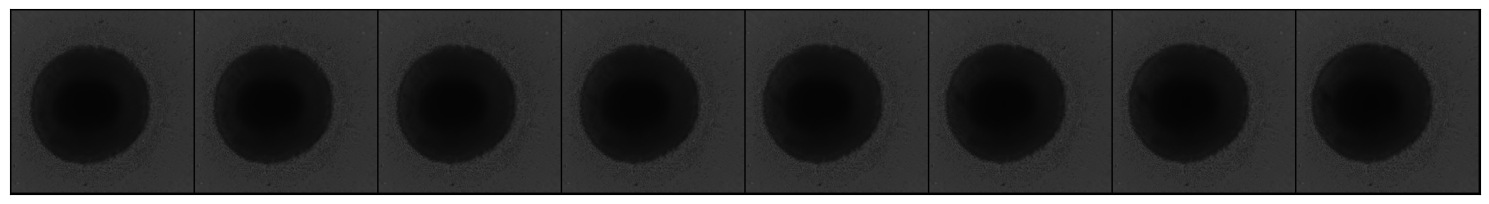

In [156]:
# Doing the projection
pl.figure(1, figsize=(15, 15))
plt = pl.subplot(111)
torch_imshow(Xinter_grid)
plt.set_xticks([])
plt.set_yticks([])
pl.tight_layout()
#pl.savefig(f'{figdir}/randomsamples.png', dpi=300)

In [120]:
trait

'Max_intensity'